In [1]:
import mlc_func.ml as mlc_func
import mlc_func.elf as elf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [93]:
nn = mlc_func.load_network('../publication/models/new/bh_qz_to_mbp_elf_filt0001/')

scale_together
INFO:tensorflow:Restoring parameters from ../publication/models/new/bh_qz_to_mbp_elf_filt0001/model.ckpt


In [95]:
# mono_offset = (np.genfromtxt('../../ElF/data/MB-pol/monomers/energies.dat') -\
#                np.genfromtxt('../../ElF/data/BH/qz_custom/monomers/energies.dat'))[0]


mono_offset = 469.79981032859143
systems = ['monomers','dimers','trimers']
basepath_tar = '../data/BH/qz_custom/'

target_src = [basepath_tar +'/' + s +'.energy_targets' for s in systems]
filters = mlc_func.get_energy_filters(target_src,
                                          autofilt_percent=0.0001)
# filters = [np.genfromtxt('../publication/data/filters/{}.filter'.format(s), dtype =bool) for s in systems]

In [96]:

def split_data(data):
    _,data = train_test_split(data, shuffle=True, random_state=42, test_size = 0.2)
    return data

def compute_energy_correction(nn, elfs, n_mol):
#     elfs = elf.utils.hdf5_to_elfs(elf_file, grouped=True, values_only=True)
    e_correction = 0
    for species in elfs:
        feat = np.array(elfs[species])
        if n_mol < 4:
            feat = feat[filters[n_mol - 1]]
            feat = split_data(feat)
        shape = feat.shape
        feat = feat.reshape(-1,shape[2])
        prediction = nn.predict(feat, species, use_masks=True)
        e_correction += np.sum(prediction.reshape(-1,shape[1]), axis = -1)
    
    return e_correction


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
156
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
400
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
300
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
50
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o

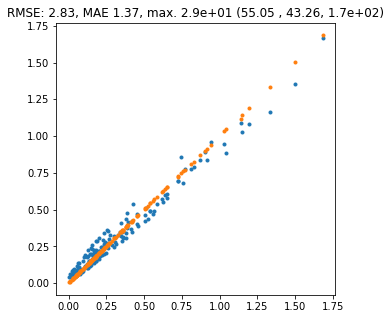

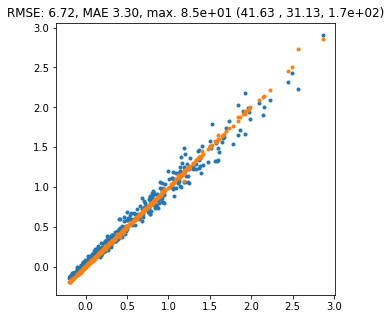

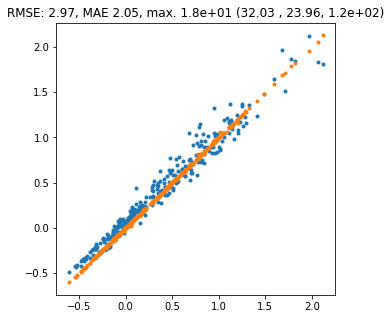

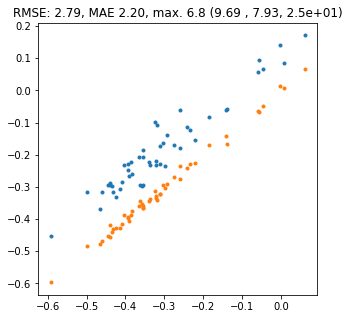

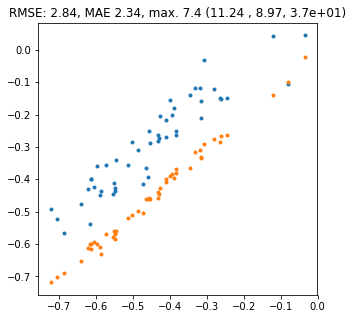

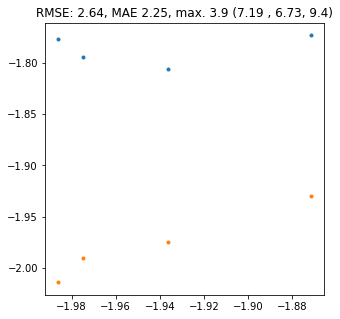

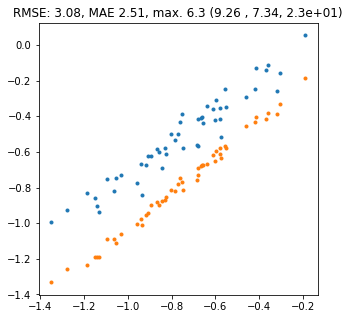

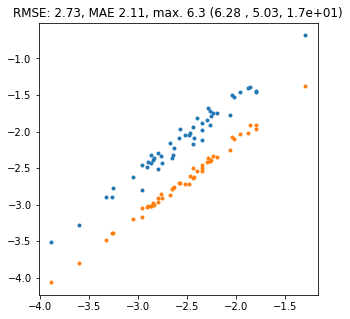

In [97]:
figsize(5,5)
errors = pd.DataFrame(columns= ['Molecules', 'RMSE','MAE','max. Error'])


for i, n_cluster in enumerate([1,2,3,4,5,6,8,16]):
# for i, n_cluster in enumerate([1]):
    elfs = elf.utils.hdf5_to_elfs('../data/BH/qz_custom/basis_nocore_elf.json_processed/{}_processed.hdf5'.format(n_cluster),
                                  grouped = True,
                                  values_only=True)
    bh = np.genfromtxt('../data/BH/qz_custom/{}.energies'.format(n_cluster)) +\
        mono_offset*n_cluster
    mbpol = np.genfromtxt('../data/MB-pol/clusters/{}/energies.dat'.format(n_cluster))
    if n_cluster <4:
        bh = bh[filters[n_cluster-1]]
        mbpol = mbpol[filters[n_cluster-1]]
        bh = split_data(bh)
        mbpol = split_data(mbpol)
    print(len(mbpol))  
    corrected =  bh + compute_energy_correction(nn, elfs, n_cluster)
    bh_err = (bh-mbpol)/n_cluster*1000
    bh_err -= np.mean(bh_err)
    corr_err = (corrected - mbpol)/n_cluster*1000
    corr_err -= np.mean(corr_err)
    figure()
    title('RMSE: {:3.2f}, MAE {:3.2f}, max. {:3.2} ({:3.2f} , {:3.2f}, {:3.2})'.format(np.std(corr_err),np.mean(np.abs(corr_err)),
                                                                  np.max(np.abs(corr_err)),
                                                                  np.std(bh_err),np.mean(np.abs(bh_err)),
                                                                  np.max(np.abs(bh_err))))
    plot(mbpol, bh, ls = '', marker = '.')
    plot(mbpol, corrected, ls = '', marker = '.')
    
    errors = errors.append(pd.DataFrame({'Molecules': [n_cluster],
                                'RMSE': ['{:3.2f} ({:3.2f})'.format(np.std(corr_err),np.std(bh_err))],
                                'MAE': ['{:3.2f} ({:3.2f})'.format(np.mean(np.abs(corr_err)),np.mean(np.abs(bh_err)))],
                                'max. Error': ['{:3.2f} ({:3.2f})'.format(np.max(np.abs(corr_err)),np.max(np.abs(bh_err)))]}),ignore_index = True)
                                
    

In [98]:
errors.index = errors['Molecules']

errors = errors.drop('Molecules', 1)
errors = errors.drop(6)


In [12]:
print(errors.to_latex())

\begin{tabular}{llll}
\toprule
{} &          RMSE &           MAE &      max. Error \\
Molecules &               &               &                 \\
\midrule
1         &  3.27 (53.70) &  1.42 (42.59) &  31.07 (148.73) \\
2         &  5.01 (40.00) &  3.33 (31.17) &  29.61 (137.12) \\
3         &  3.38 (28.54) &  2.51 (22.36) &   21.39 (90.33) \\
4         &   2.77 (9.69) &   2.33 (7.93) &    6.47 (24.95) \\
5         &  3.21 (11.24) &   2.66 (8.97) &    6.85 (36.69) \\
8         &   3.45 (9.26) &   2.86 (7.34) &    6.88 (22.67) \\
16        &   3.30 (6.28) &   2.53 (5.03) &    7.56 (17.15) \\
\bottomrule
\end{tabular}



In [99]:
print(errors.to_latex())

\begin{tabular}{llll}
\toprule
{} &          RMSE &           MAE &      max. Error \\
Molecules &               &               &                 \\
\midrule
1         &  2.83 (55.05) &  1.37 (43.26) &  28.81 (173.88) \\
2         &  6.72 (41.63) &  3.30 (31.13) &  84.82 (173.33) \\
3         &  2.97 (32.03) &  2.05 (23.96) &  17.57 (118.34) \\
4         &   2.79 (9.69) &   2.20 (7.93) &    6.82 (24.95) \\
5         &  2.84 (11.24) &   2.34 (8.97) &    7.40 (36.69) \\
8         &   3.08 (9.26) &   2.51 (7.34) &    6.31 (22.67) \\
16        &   2.73 (6.28) &   2.11 (5.03) &    6.27 (17.15) \\
\bottomrule
\end{tabular}



In [100]:
n_cluster = 6
elfs = elf.utils.hdf5_to_elfs('../data/BH/qz_custom/basis_nocore_elf.json_processed/{}_processed.hdf5'.format(n_cluster),
                                  grouped = True,
                                  values_only=True)
bh = np.genfromtxt('../data/BH/qz_custom/6.energies') + mono_offset*6
mbpol = np.genfromtxt('../data/MB-pol/clusters/6/energies.dat'.format(n_cluster))
corrected = bh + compute_energy_correction(nn, elfs,6)
# subplot(2,2,i+1)
# plot(mbpol, bh, ls = '', marker = '.')
# plot(mbpol, bh + compute_energy_correction(nn, elfs), ls = '', marker = '.')

{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
Sharing scaler with species o
Sharing scaler with species h


In [101]:
rcParams['text.usetex'] = False

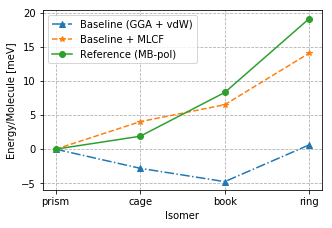

In [102]:
bh -= bh[0]
corrected -= corrected[0]
mbpol -= mbpol[0]
figsize(5,3.3)

plot(bh*1000/6, ls = '-.', label = 'Baseline (GGA + vdW)', marker = '^')
plot(corrected*1000/6,ls = '--', label = 'Baseline + MLCF', marker = '*')
plot(mbpol*1000/6, ls = '-', label = 'Reference (MB-pol)', marker = 'o')
legend()
ylabel('Energy/Molecule [meV]')
xlabel('Isomer')
xticks([0,1,2,3],['prism','cage','book','ring'])
grid(ls = '--')
# savefig('../publication/figures/hexamers.pdf', bbox_inches='tight')
# savefig('../publication/figures/hexamers.eps', bbox_inches='tight')

In [103]:
def n_body_energy(energies):
    
    n_systems = len(energies[0])
    nb_energy = np.array(energies[0])
    for i,e in enumerate(energies[1:]):
        nb_energy -= (-1)**i*np.sum(e.reshape(n_systems,-1), axis = -1)
        
    return nb_energy

In [104]:
energies = {}

directories = ['trimers','trimers_dimers','trimers_mono']
# directories = ['dimers', 'dimers_mono']
basedir = '../data/'
locations = ['BH/qz_custom','MB-pol']
locations_dir = [ basedir + l + '/mbe/' for l in locations]
energies['BH + MLCF'] = []
for i, l in enumerate(locations_dir):
    name = locations[i].split('/')[0]
    energies[name] = []
    for d in directories:
        try:
            energies[name].append(np.genfromtxt(l + d + '/energies.dat'))
        except OSError:
            energies[name].append(np.genfromtxt(l  + d + '.energies'))
            
        if name == 'BH':
            elfs = elf.utils.hdf5_to_elfs(basedir + name + '/qz_custom/mbe/basis_nocore_elf.json_processed/' + d + '_processed.hdf5',
                                  grouped = True,
                                  values_only=True)
            energies['BH + MLCF'].append(energies[name][-1] + compute_energy_correction(nn,elfs,100))
energies_3b = energies



energies = {}

# directories = ['trimers','trimers_dimers','trimers_mono']
directories = ['dimers', 'dimers_mono']
basedir = '../data/'
locations = ['BH/qz_custom','MB-pol']
locations_dir = [ basedir + l + '/mbe/' for l in locations]
energies['BH + MLCF'] = []
for i, l in enumerate(locations_dir):
    name = locations[i].split('/')[0]
    energies[name] = []
    for d in directories:
        try:
            energies[name].append(np.genfromtxt(l + d + '/energies.dat'))
        except OSError:
            energies[name].append(np.genfromtxt(l  + d + '.energies'))
            
        if name == 'BH':
            elfs = elf.utils.hdf5_to_elfs(basedir + name + '/qz_custom/mbe/basis_nocore_elf.json_processed/' + d + '_processed.hdf5',
                                  grouped = True,
                                  values_only=True)
            energies['BH + MLCF'].append(energies[name][-1] + compute_energy_correction(nn,elfs,100))
energies_2b = energies



{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
Sharing scaler with species o
Sharing scaler with species h
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h'

2.3094936616212873
4.198587367239641
3.7864051624106025
7.098627408987373


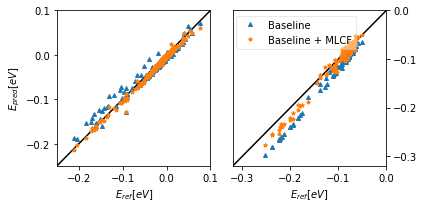

In [105]:

figsize(6,3)
n_b = {}
for key in energies:
    n_b[key] = n_body_energy(energies_2b[key])
ax1 = subplot(1,2,1)

ticks = [-0.2,-0.1,0,0.1]
min_,max_ = -0.25,0.1

# ax1.axis('equal')
ax1.axis([min_,max_,min_,max_])
# ax.xaxis.lim(min_,max_)
# ax.yaxis.ylim(min_,max_)
ax1.plot([min_,max_], [min_,max_], color = 'black')
ax1.plot(n_b['MB-pol'],n_b['BH'],  ls = '', marker = '^', label = 'Baseline (GGA + vdW)', ms = 4.0)
ax1.plot( n_b['MB-pol'], n_b['BH + MLCF'], ls = '', marker = '*', label = 'Baseline + MLCF', ms = 4.0)

ylabel('$E_{pred} [eV]$')
xlabel('$E_{ref} [eV]$')
# ax1.axis('tight')
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
# ax1.xaxis.tick_top()
rmse_mlcf = np.sqrt(np.mean((n_b['BH + MLCF'] - n_b['MB-pol'])**2))*1000/2
rmse_bh = np.sqrt(np.mean((n_b['BH'] - n_b['MB-pol'])**2))*1000/2
print(rmse_mlcf)
print(rmse_bh)
# savefig('../publication/figures/2b.pdf', bbox_inches='tight')
# savefig('../publication/figures/2b.eps', bbox_inches='tight')

n_b = {}

for key in energies:
    n_b[key] = n_body_energy(energies_3b[key])
    
ax2 = subplot(1,2,2)
ticks = [0,-0.1,-0.2,-0.3]
min_,max_ = -0.32,-0.00
ax2.axis([min_,max_,min_,max_])
# xlim(min_,max_)
# ylim(min_,max_)

ax2.plot([min_,max_], [min_,max_], color = 'black')
ax2.plot( n_b['MB-pol'], n_b['BH'], ls = '', marker = '^', label = 'Baseline', ms = 4.0)
ax2.plot(n_b['MB-pol'], n_b['BH + MLCF'],  ls = '', marker = '*', label = 'Baseline + MLCF', ms = 4.0)
# ylabel('$E_{ref} [eV]$')
xlabel('$E_{ref} [eV]$')
xticks(ticks)
yticks(ticks)
ax2.yaxis.tick_right()
# ax2.xaxis.tick_top()
# legend()
tight_layout()
rmse_mlcf = np.sqrt(np.mean((n_b['BH + MLCF'] - n_b['MB-pol'])**2))*1000/3
rmse_bh = np.sqrt(np.mean((n_b['BH'] - n_b['MB-pol'])**2))*1000/3
legend(bbox_to_anchor=(-0.01, 0.72, 1.5, .102),fancybox= True, framealpha = .4)
print(rmse_mlcf)
print(rmse_bh)
# savefig('../publication/figures/mbe.pdf', bbox_inches='tight')
# savefig('../publication/figures/mbe.eps', bbox_inches='tight')




2.9382812397619618
4.198587367239641
3.171581589115865
7.098627408987373


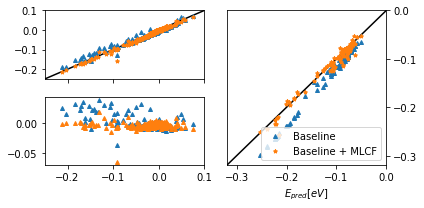

In [63]:
figsize(6,3)
n_b = {}
for key in energies:
    n_b[key] = n_body_energy(energies_2b[key])
f, ((ax1, ax2), (ax3, ax4)) = subplots(2,2, sharex = 'col')

ticks = [-0.2,-0.1,0,0.1]
min_,max_ = -0.25,0.1

# ax1.axis('equal')
ax1.axis([min_,max_,min_,max_])
# ax.xaxis.lim(min_,max_)
# ax.yaxis.ylim(min_,max_)
ax1.plot([min_,max_], [min_,max_], color = 'black')
ax1.plot(n_b['MB-pol'], n_b['BH'],  ls = '', marker = '^', label = 'Baseline (GGA + vdW)', ms = 4.0)
ax1.plot( n_b['MB-pol'], n_b['BH + MLCF'], ls = '', marker = '*', label = 'Baseline + MLCF', ms = 4.0)

ylabel('$E_{ref} [eV]$')
xlabel('$E_{pred} [eV]$')
# ax1.axis('tight')
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
# ax1.xaxis.tick_top()
rmse_mlcf = np.sqrt(np.mean((n_b['BH + MLCF'] - n_b['MB-pol'])**2))*1000/2
rmse_bh = np.sqrt(np.mean((n_b['BH'] - n_b['MB-pol'])**2))*1000/2
print(rmse_mlcf)
print(rmse_bh)
# savefig('../publication/figures/2b.pdf', bbox_inches='tight')
# savefig('../publication/figures/2b.eps', bbox_inches='tight')

ax3.plot(n_b['MB-pol'], n_b['BH'] - n_b['MB-pol'], ls = '', marker = '^', label = 'Baseline', ms = 4.0)
ax3.plot(n_b['MB-pol'], n_b['BH + MLCF'] - n_b['MB-pol'], ls = '', marker = '^', label = 'Baseline', ms = 4.0)

n_b = {}

for key in energies:
    n_b[key] = n_body_energy(energies_3b[key])
    
ax2 = subplot(1,2,2)
ticks = [0,-0.1,-0.2,-0.3]
min_,max_ = -0.32,-0.00
ax2.axis([min_,max_,min_,max_])
# xlim(min_,max_)
# ylim(min_,max_)

ax2.plot([min_,max_], [min_,max_], color = 'black')
ax2.plot(n_b['MB-pol'], n_b['BH'],  ls = '', marker = '^', label = 'Baseline', ms = 4.0)
ax2.plot( n_b['MB-pol'], n_b['BH + MLCF'], ls = '', marker = '*', label = 'Baseline + MLCF', ms = 4.0)
# ylabel('$E_{ref} [eV]$')
xlabel('$E_{pred} [eV]$')
xticks(ticks)
yticks(ticks)
ax2.yaxis.tick_right()
# ax2.xaxis.tick_top()
# legend()
tight_layout()
rmse_mlcf = np.sqrt(np.mean((n_b['BH + MLCF'] - n_b['MB-pol'])**2))*1000/3
rmse_bh = np.sqrt(np.mean((n_b['BH'] - n_b['MB-pol'])**2))*1000/3
legend()
print(rmse_mlcf)
print(rmse_bh)
# savefig('../publication/figures/mbe.pdf', bbox_inches='tight')
# savefig('../publication/figures/mbe.eps', bbox_inches='tight')

ax4.plot(n_b['MB-pol'], n_b['BH'] - n_b['MB-pol'], ls = '', marker = '^', label = 'Baseline', ms = 4.0)
ax4.plot(n_b['MB-pol'], n_b['BH + MLCF'] - n_b['MB-pol'], ls = '', marker = '^', label = 'Baseline', ms = 4.0)